# Advanced Tutorial for the MFF Package <br/>

In this jupyter notebook, most of the uses of the MFF package will be thoroughly analysed and explained.

In [42]:
# Standard Imports
import logging
import numpy as np
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.ERROR)  # Verbosity selection: INFO, WARNING or ERROR
# import ASE
from ase.io import read
from ase.io import write
from ase import Atoms
# Import MFF
from mff import utility, configurations, models, calculators
from pathlib import Path

# Atoms visualization Tool
from IPython.display import HTML

def atoms_to_html(atoms):
    'Return the html representation the atoms object as string'

    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html = ntf.read()
    return html

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

# First System: Nickel 19 nanoparticle

### Import the .xyz file and convert it to local atomic environment data

In [43]:
directory = Path('data/Ni_19/')             # Path to the directory that contains the trajectory file, and where all of the files will be saved
filename = directory / 'movie.xyz'       # name of the trajectory file
cutoff = 6.4                             # Cutoff to be used to carve local atomic environemnts, in Angstrom

data = configurations.generate_and_save(filename, cutoff, forces_label='forces', energy_label='energy')   # Generate and save the compressed "data" object that contains all the information
elements, confs, forces, energies, global_confs = configurations.load_and_unpack(directory, cutoff) # Extract the information from the zipped data object which is located in the directory

In [44]:
atoms = read(filename, index = 0)
atoms.set_positions(atoms.get_positions() - 12*np.ones_like(atoms.get_positions))
nickel = atoms_to_html(atoms)
HTML(nickel)

### Generate a 2-body GP and train it using force data only

In [45]:
ntr = 200
ntest = 100
ntest_en = 50
sigma = 0.5
noise = 0.001
theta = 0.5

# Choose data at random from the force database and split into training/test data
ind_f = np.random.choice(np.arange(len(confs)),  ntr+ntest, replace = False)
ind_tr, ind_test = ind_f[:ntr], ind_f[ntr:]

# Choose data at random from the energy database for testing
ind_test_en = np.random.choice(np.arange(len(global_confs)), ntest_en, replace = False)

# Initialize the model
m1 = models.TwoBodySingleSpeciesModel(elements, cutoff, sigma, theta, noise)

# Fit using local atomic environment and force data using 2 cores
m1.fit(confs[ind_tr], forces[ind_tr], ncores = 2)

Loading Kernels


### Test the accuracy of the GP-FF on force and energy data

Testing the force prediction on 100 configurations

RMSE: 0.1465 eV/A
MAEC: 0.1112 eV/A
MAEF : 0.2215 +- 0.1239 eV/A
Relative MAEF: 0.3688 +- 0.2063


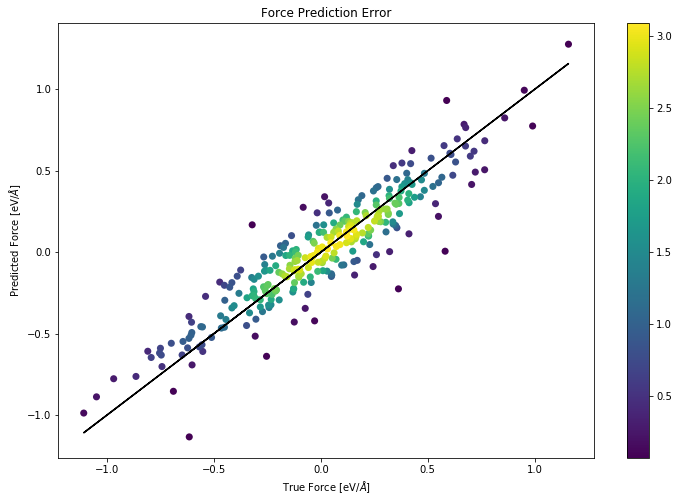

In [46]:
MAEC, MAEF, SMAEF, MF, RMSEF = utility.test_forces(m1, confs[ind_test], forces[ind_test], plot = True, ncores = 2)

Testing the energy prediction on 50 configurations

Energy RMSE: 1.767 eV/atom
Energy MAE : 1.7673 +- 0.0210 eV/atom


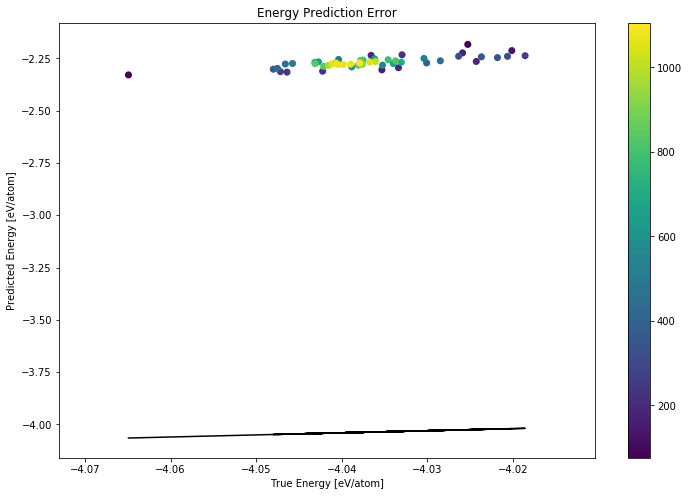

In [47]:
MAE, SMAE, RMSE_e = utility.test_energies(m1, global_confs[ind_test_en], energies[ind_test_en], plot = True, ncores = 2)

The accuracy on the force vectors is good, but we are not really taking into account the energy of the system. <br>
It is therefore better to fit using a large amount of force data, and a smalla amount of energy data, in order to give the GP some reference points for the energetic values, and not only for its gradient (force).

### Generate a 2-body GP and train it using force and energy data to improve its accuracy on energy predictions

In [48]:
ntr = 200
ntest = 100
ntr_en = 1
ntest_en = 50
sigma = 0.5
noise = 0.001
theta = 0.5

# Choose data at random from the force database and split into training/test data
ind_f = np.random.choice(np.arange(len(confs)),  ntr+ntest, replace = False)
ind_tr, ind_test = ind_f[:ntr], ind_f[ntr:]

# Choose data at random from the energy database for testing
ind_e = np.random.choice(np.arange(len(global_confs)),  ntr_en+ntest_en, replace = False)
ind_tr_en, ind_test_en = ind_e[:ntr_en], ind_e[ntr_en:]

# Initialize the model
m2 = models.TwoBodySingleSpeciesModel(elements, cutoff, sigma, theta, noise)

# Fit using local atomic environment and force data using 2 cores
m2.fit_force_and_energy(confs[ind_tr], forces[ind_tr], global_confs[ind_tr_en], energies[ind_tr_en], ncores = 2)

Loading Kernels


### Test the accuracy of the second GP-FF on force and energy data

Testing the force prediction on 100 configurations

RMSE: 0.1578 eV/A
MAEC: 0.1208 eV/A
MAEF : 0.2422 +- 0.1267 eV/A
Relative MAEF: 0.4044 +- 0.2116


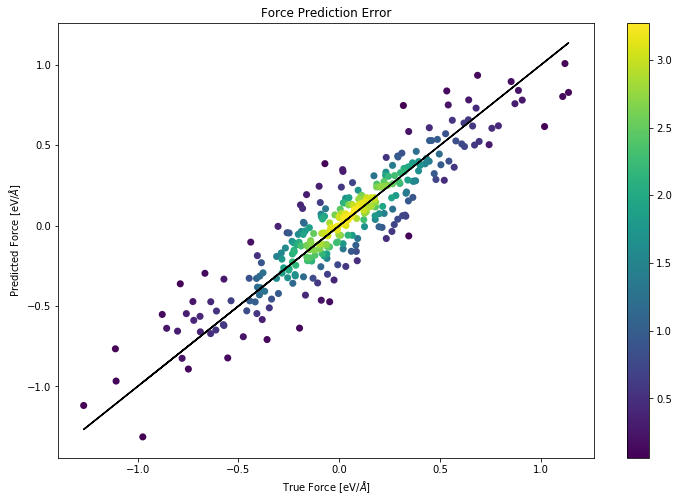

In [49]:
MAEC, MAEF, SMAEF, MF, RMSEF = utility.test_forces(m2, confs[ind_test], forces[ind_test], plot = True, ncores = 2)

Testing the energy prediction on 50 configurations

Energy RMSE: 0.03831 eV/atom
Energy MAE : 0.0277 +- 0.0265 eV/atom


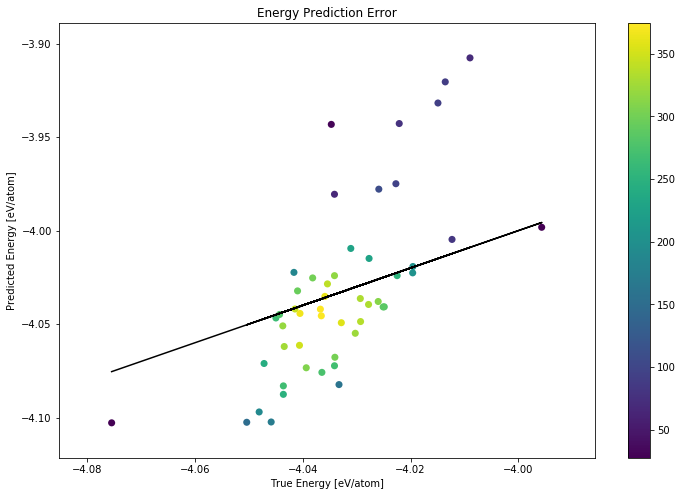

In [50]:
MAE, SMAE, RMSE_e = utility.test_energies(m2, global_confs[ind_test_en], energies[ind_test_en], plot = True, ncores = 2)

### Visualize the 2-body FF-s

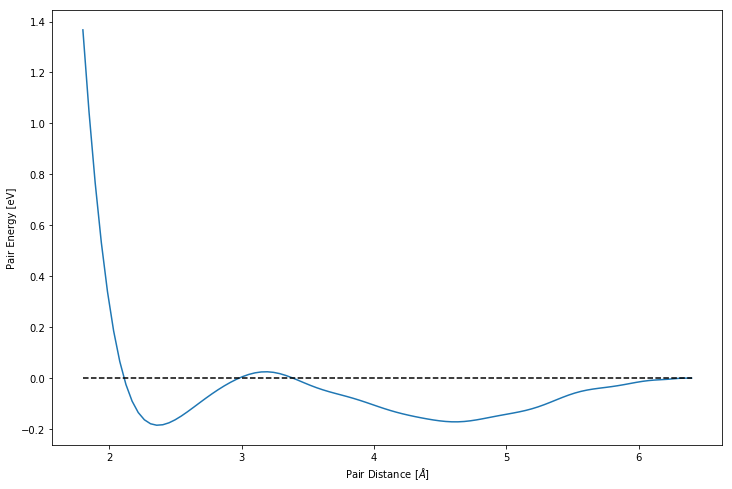

In [51]:
distances = np.linspace(1.8, cutoff, 100)
en = np.zeros(len(distances))
for i, c in enumerate(distances):
    conf = np.array([[[[c, 0, 0, elements[0], elements[0]]]]])
    en[i] = m1.predict_energy(conf, ncores=1)
    
plt.plot(distances, en)
plt.plot(distances, np.zeros(len(distances)), 'k--')
plt.ylabel('Pair Energy [eV]')
plt.xlabel(r'Pair Distance [$\AA$]')
plt.show()

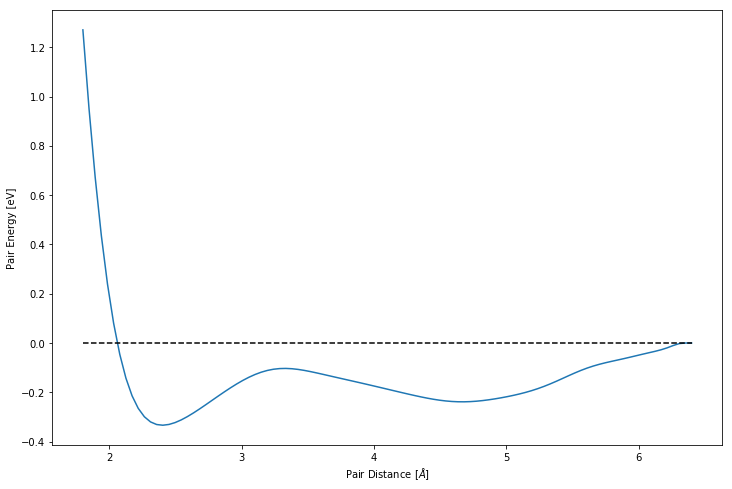

In [52]:
distances = np.linspace(1.8, cutoff, 100)
en = np.zeros(len(distances))
for i, c in enumerate(distances):
    conf = np.array([[[[c, 0, 0, elements[0], elements[0]]]]])
    en[i] = m2.predict_energy(conf, ncores=1)
    
plt.plot(distances, en)
plt.plot(distances, np.zeros(len(distances)), 'k--')
plt.ylabel('Pair Energy [eV]')
plt.xlabel(r'Pair Distance [$\AA$]')
plt.show()

### Map the GP-FFs into M-FFs

In [53]:
m1.build_grid(1.0, 100, ncores = 2)

m2.build_grid(1.0, 100, ncores = 2)

m1.save(directory / "models")

m2.save(directory / "models")

Saved model with name: MODEL_ker_TwoBodySingleSpecies_ntr_200.json
Saved model with name: MODEL_ker_TwoBodySingleSpecies_ntr_201.json


### Setup a Simulation in ASE

In [54]:
# Additional ASE imports
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units
from ase.io import extxyz

# Global Variables Definition
gamma = 0.001 #  For Langevin Dynamics
temp = 500 # K
dt = 1.0  # fs
cell_length = 10.0 # Angstrom

atoms = read(filename, index=0, format='extxyz')  # Read the input file and setup the initial geometry form the xyz file
atoms.set_positions(atoms.get_positions() - 0.5*np.array([cell_length, cell_length, cell_length]))  # Center atoms in the cell
atoms.set_cell([[cell_length, 0.0, 0.0], [0, cell_length, 0], [0, 0, cell_length]]) # Set the simulation cell if not present
atoms.set_pbc([False, False, False])

In [55]:
def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def savexyz(a=atoms):
    this_traj = open(output_name, "a")
    extxyz.write_extxyz(this_traj, [atoms])

### Launch Simulation With m1

In [56]:
calc1 = calculators.TwoBodySingleSpecies(cutoff, m1.grid)  # Initialize calculator module
atoms.set_calculator(calc1) # Tell ASE how to get the forces ( AKA choose the potential)

# Setup the momenta and velocities
dyn = VelocityVerlet(atoms, dt * units.fs)  # The dynamics will be a Verlet one
MaxwellBoltzmannDistribution(atoms, 2.0 * temp * units.kB)  # Initialize velocities according to MB distribution at double T because of equipartition theorem
ZeroRotation(atoms)  # Stop global rotation
Stationary(atoms)  # Stop global movement

In [57]:
steps = 1000

output_name = "data/Ni_19/trajectory_mff_1.xyz"  # Output name
this_traj = open(output_name, "w")
dyn.attach(savexyz, interval=100)  # Save coordinates every interval steps
dyn.attach(printenergy, interval=100)  # Print informations every interval steps
dyn.run(steps)  # Have fun
this_traj.close()

/opt/conda/lib/python3.6/site-packages/ase/io/extxyz.py:844: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  'from calculator'.format(key))


Energy per atom: Epot = -2.345eV  Ekin = 0.108eV (T=832K)  Etot = -2.237eV
Energy per atom: Epot = -2.197eV  Ekin = 0.034eV (T=263K)  Etot = -2.164eV
Energy per atom: Epot = -2.238eV  Ekin = 0.054eV (T=419K)  Etot = -2.184eV
Energy per atom: Epot = -2.207eV  Ekin = 0.039eV (T=301K)  Etot = -2.168eV
Energy per atom: Epot = -2.240eV  Ekin = 0.055eV (T=428K)  Etot = -2.185eV
Energy per atom: Epot = -2.202eV  Ekin = 0.036eV (T=279K)  Etot = -2.166eV
Energy per atom: Epot = -2.241eV  Ekin = 0.056eV (T=430K)  Etot = -2.185eV
Energy per atom: Epot = -2.227eV  Ekin = 0.049eV (T=378K)  Etot = -2.178eV
Energy per atom: Epot = -2.216eV  Ekin = 0.043eV (T=334K)  Etot = -2.173eV
Energy per atom: Epot = -2.228eV  Ekin = 0.049eV (T=382K)  Etot = -2.179eV
Energy per atom: Epot = -2.209eV  Ekin = 0.040eV (T=307K)  Etot = -2.169eV


### Launch Simulation With m2

In [58]:
calc2 = calculators.TwoBodySingleSpecies(cutoff, m2.grid)  # Initialize calculator module
atoms.set_calculator(calc2) # Tell ASE how to get the forces ( AKA choose the potential)

# Setup the momenta and velocities
dyn = VelocityVerlet(atoms, dt * units.fs)  # The dynamics will be a Verlet one
MaxwellBoltzmannDistribution(atoms, 2.0 * temp * units.kB)  # Initialize velocities according to MB distribution at double T because of equipartition theorem
ZeroRotation(atoms)  # Stop global rotation
Stationary(atoms)  # Stop global movement

In [59]:
steps = 1000

output_name = "data/Ni_19/trajectory_mff_2.xyz"  # Output name
this_traj = open(output_name, "w")
dyn.attach(savexyz, interval=100)  # Save coordinates every interval steps
dyn.attach(printenergy, interval=100)  # Print informations every interval steps
dyn.run(steps)  # Have fun
this_traj.close()

Energy per atom: Epot = -3.977eV  Ekin = 0.168eV (T=1301K)  Etot = -3.809eV


/opt/conda/lib/python3.6/site-packages/ase/io/extxyz.py:844: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  'from calculator'.format(key))


Energy per atom: Epot = -3.808eV  Ekin = 0.084eV (T=648K)  Etot = -3.724eV
Energy per atom: Epot = -3.878eV  Ekin = 0.119eV (T=920K)  Etot = -3.759eV
Energy per atom: Epot = -3.824eV  Ekin = 0.092eV (T=711K)  Etot = -3.732eV
Energy per atom: Epot = -3.877eV  Ekin = 0.118eV (T=916K)  Etot = -3.759eV
Energy per atom: Epot = -3.820eV  Ekin = 0.090eV (T=693K)  Etot = -3.730eV
Energy per atom: Epot = -3.854eV  Ekin = 0.107eV (T=825K)  Etot = -3.747eV
Energy per atom: Epot = -3.884eV  Ekin = 0.122eV (T=940K)  Etot = -3.762eV
Energy per atom: Epot = -3.837eV  Ekin = 0.098eV (T=758K)  Etot = -3.739eV
Energy per atom: Epot = -3.927eV  Ekin = 0.143eV (T=1109K)  Etot = -3.784eV
Energy per atom: Epot = -3.930eV  Ekin = 0.145eV (T=1121K)  Etot = -3.785eV


# Second System: Fe with grain boundaries

In [61]:
directory = Path('data/Fe/')             # Path to the directory that contains the trajectory file, and where all of the files will be saved
filename = directory / 'movie.xyz'       # name of the trajectory file
cutoff = 4.45                             # Cutoff to be used to carve local atomic environemnts, in Angstrom

elements, confs, forces, energies, global_confs = configurations.load_and_unpack(directory, cutoff) # Extract the information from the zipped data object which is located in the directory

In [64]:
atoms = read(filename, index = 0)
iron = atoms_to_html(atoms)
HTML(iron)

In [16]:
ntr = 200
ntest = 100
ntr_en = 1
ntest_en = 50
sigma = 0.5
noise = 0.001
theta = 0.5

# Choose data at random from the force database and split into training/test data
ind_f = np.random.choice(np.arange(len(confs)),  ntr+ntest, replace = False)
ind_tr, ind_test = ind_f[:ntr], ind_f[ntr:]

# Choose data at random from the energy database for testing
ind_e = np.random.choice(np.arange(len(global_confs)),  ntr_en+ntest_en, replace = False)
ind_tr_en, ind_test_en = ind_e[:ntr_en], ind_e[ntr_en:]

# Load the model
m3 = utility.load_model(directory / "models" / "MODEL_combined_ntr_200.json")


Loading Kernels
Loading Kernels
Loaded GP from file
Loaded GP from file


Testing the force prediction on 100 configurations

RMSE: 0.07023 eV/A
MAEC: 0.04975 eV/A
MAEF : 0.0999 +- 0.0694 eV/A
Relative MAEF: 0.1130 +- 0.0784


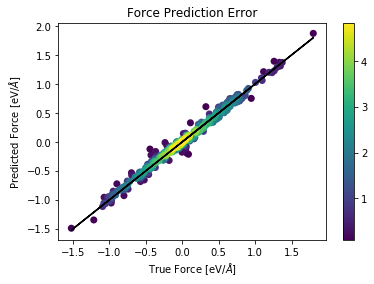

In [17]:
MAEC, MAEF, SMAEF, MF, RMSEF = utility.test_forces(m3, confs[ind_test], forces[ind_test], plot = True, ncores = 2)